##### Introduction

**Problem**

Power consumption cost can simply be calculated using the formula `Cost = KiloWatt Per Hour x Generation Rate`. 

However, the actual cost seems to be larger due to additional variables such as transmission cost, value added tax, and other miscalleneous fees.

Without knowing the additional fees, how do we consider a rough estimate for the actual cost of the amount of power consumed by a household?

**Objective**

To create a three dimensional ordinary least square regression model for projecting the actual electricity cost.

**Scope**

This model is catered for  *residential* electricity billings under *Cepalco (located in Misamis Oriental)*.

It does not adapt if the additional fees were to significantly update. 

##### Resource

Libraries

In [1458]:
# dataframe library
import pandas as pd

# matrix library
import numpy as np

# statistic library
import statsmodels.api as sm

# chart library
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('./asset/theme.mplstyle')

Functions

In [1459]:
def plot_scatter_and_regression(df, axes, x_column, y_column, band_width=0):
    # Scatter plot
    axes.scatter(df[x_column], df[y_column], label='Data')
    axes.set_xlabel(x_column, fontsize=7)
    axes.set_ylabel(y_column, fontsize=7)
    axes.set_title(f'{x_column} vs {y_column}', fontsize=7)

    # Fit a linear regression line
    x_min = df[x_column].min()
    x_max = df[x_column].max()
    x_vals = np.linspace(x_min, x_max, 100)
    y_fit  = np.polyfit(df[x_column], df[y_column], 1)
    y_vals = np.polyval(y_fit, x_vals)

    # Plot regression line
    axes.plot(x_vals, y_vals, color='magenta', linewidth=2, label='Regression Line')
    
    # Set axis ticks size
    axes.tick_params(axis='both', which='major', labelsize=7)

    # Plot shaded area around the regression line
    axes.fill_between(x_vals, y_vals - band_width, y_vals + band_width, color='magenta', alpha=0.2, label=f'Error +/-{band_width}')
    
    # show legend on the upper left
    axes.legend(loc='upper left', fontsize=7)

In [1460]:
def plot_3d_regression(df, x1_label, x2_label, y_label):
    x1 = df[x1_label]
    x2 = df[x2_label]
    y  = df[y_label]
    
    # Create a 3D plot with adjusted width and height
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # Fit a linear regression model
    A = np.column_stack((np.ones_like(x1), x1, x2))
    b = y.values.reshape((-1, 1))
    beta_hat = np.linalg.lstsq(A, b, rcond=None)[0]

    # Generate points for the plane
    x1_plane, x2_plane = np.meshgrid(np.linspace(min(x1), max(x1), 100), np.linspace(min(x2), max(x2), 100))
    y_plane = beta_hat[0] + beta_hat[1] * x1_plane + beta_hat[2] * x2_plane

    # Create a colormap for z-values
    cmap = plt.colormaps['cool']

    # Plot the points and the plane with adjusted alpha and color
    surf = ax.plot_surface(x2_plane, x1_plane, y_plane, alpha=0.2, label='Projected Cost') 
    sc = ax.scatter(x2, x1, y, c=y, cmap=cmap, marker='o', label='Recorded Cost')
    
    # Set background transparency for the axis planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Set labels and title with adjusted font sizes
    ax.set_xlabel(x1_label, fontsize=7)
    ax.set_ylabel(x2_label, fontsize=7)
    ax.set_zlabel(y_label, fontsize=7)

    # Set axis label font size
    ax.tick_params(axis='both', which='major', labelsize=7)

    # Adjust aspect ratio
    ax.set_box_aspect([1.5, 1, 2])  # You can adjust the values to control the aspect ratio
    
    # Show legend on the upper left
    ax.legend(loc='upper left', fontsize=9)

    # Create a colorbar for reference
    cbar = fig.colorbar(sc, ax=ax, shrink=0.4)
    cbar.ax.tick_params(labelsize=7)

    # Show the plot with adjusted width and height
    plt.show()

##### Retrieve

In [1461]:
# dataframe object
df = pd.read_excel('./data/data.xlsx')

# convert FROM and TO into count DAYS 
df['FROM'] = pd.to_datetime(df['FROM'])
df['TO']   = pd.to_datetime(df['TO'])
df['DAYS'] = (df['TO'] - df['FROM']).dt.days
df.tail(n=5) # view dataframe    

,FROM,TO,DAYS,GENERATION_RATE,KWH_CONSUMED,CALCULATED,TRANSMISSION_SUBTOTAL,TOTAL_AMOUNT,DIFFERENCE
36,2020-06-01,2020-07-01,30,6.9788,199,1388.7812,1499.71,2339.41,839.70
37,2020-05-01,2020-06-01,31,7.0776,230,1627.8480,1747.02,2704.36,957.34
38,2020-03-31,2020-05-01,31,7.0367,243,1709.9181,1849.57,2855.60,1006.03
39,2020-03-03,2020-03-31,28,6.9942,197,1377.8574,1487.55,2315.98,828.43
40,2020-01-31,2020-03-03,32,6.7743,199,1348.0857,1462.54,2296.35,833.81


##### Relation

In [1462]:
independent = ['GENERATION_RATE', 'KWH_CONSUMED']
dependent   = 'TOTAL_AMOUNT'

In [1463]:
correlation_rate  = df[independent[0]].corr(df[dependent])
correlation_power = df[independent[1]].corr(df[dependent])
correlation_rate, correlation_power

(0.6580274915942472, 0.4218843652733225)

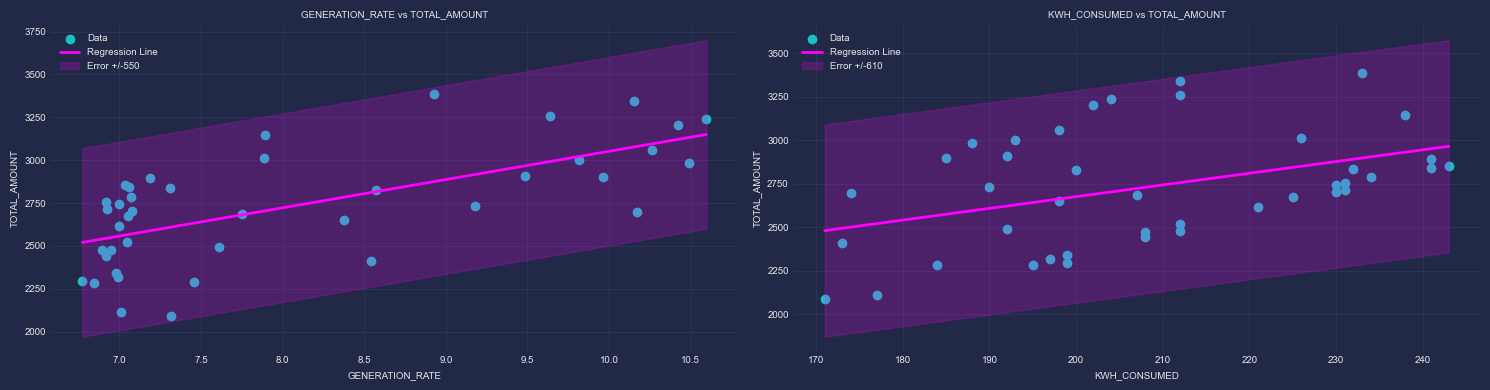

In [1464]:
# setup subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# plot scatter and regression    
plot_scatter_and_regression(df, axes[0], independent[0], dependent, 550)
plot_scatter_and_regression(df, axes[1], independent[1], dependent, 610)

# adjust layout
plt.tight_layout()

# Show the plots
plt.show()

##### Regression

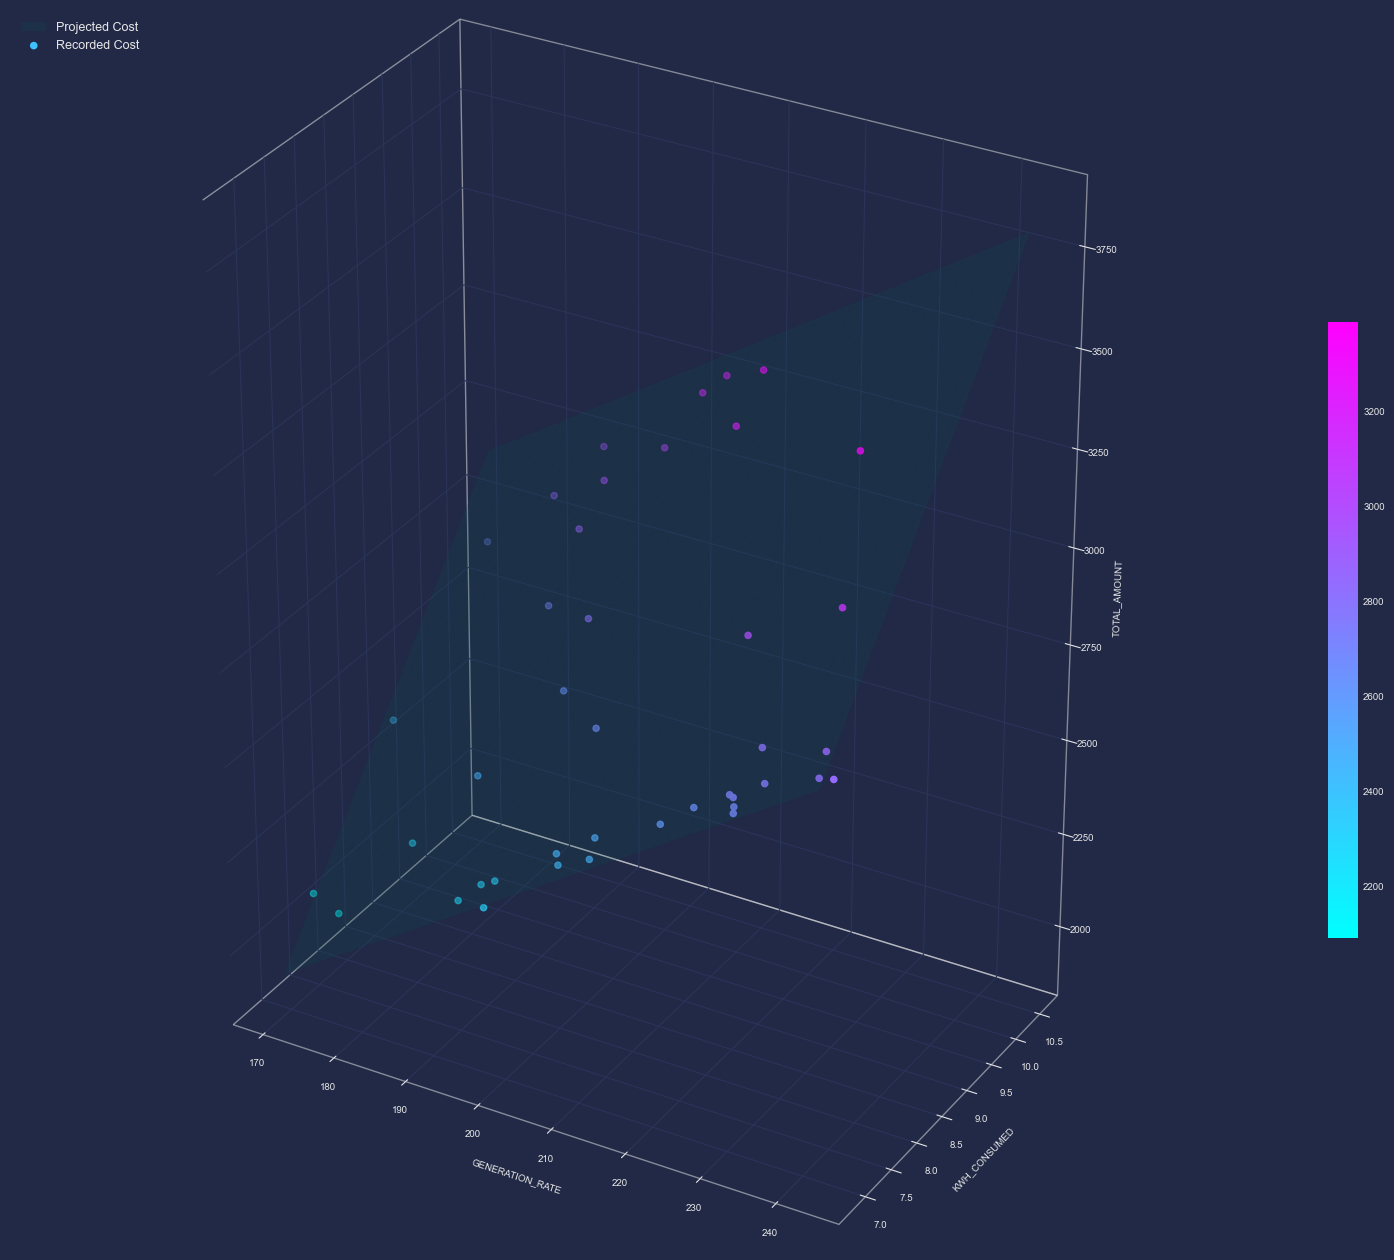

In [1465]:
plot_3d_regression(df, independent[0], independent[1], dependent)

Summary

In [1466]:
# add a constant term to the predictors
X = sm.add_constant(df[independent])

# fit the model
model = sm.OLS(df[dependent], X).fit()

# view the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TOTAL_AMOUNT   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     707.2
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           8.63e-31
Time:                        21:36:30   Log-Likelihood:                -220.72
No. Observations:                  41   AIC:                             447.4
Df Residuals:                      38   BIC:                             452.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1875.1917    128.703    -14.570      0.000   -2135.738   -1614.646
GENERATION_RATE   242.5836      7.135     33.999      0.000     228.140     257.027
KWH_CONSUMED       12.7343      0.454     28.028      0.000      11.815      13.654
==============================================================================
Omnibus:                        1.210   Durbin-Watson:                   0.657
Prob(Omnibus):                  0.546   Jarque-Bera (JB):                1.026
Skew:                           0.376   Prob(JB):                        0.599
Kurtosis:                       2.809   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Accuracy

In [1467]:
# Calculate predicted values
predicted_values = model.predict(X)

# Calculate absolute percentage errors
absolute_percentage_errors = np.abs((df[dependent] - predicted_values) / df[dependent])

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(absolute_percentage_errors) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 1.47%
Accuracy: 98.53%


##### Conclusion

As of December 2023, the model is 98.53% accurate and fits 97.4% of the data.

With 95% confidence, actual values will fall within ±128 pesos of the predidcted values. 

Unless the *scoped fees* have updated significantly, the actual deviation for any specific observation could be more or less than 150 pesos, but on average, you would expect deviations of about that magnitude.

Potential future tweaks for this model is to allow it to adapt changes from new data.